# Loading modules

If the packages don't load, you'll need to install them using `Pkg.add("module_name")` or from the command line using the `]` to `>pkg` environment.

In [7]:
using NewBioSimulator
# import NewBioSimulator: parse_model

using Combinatorics, SparseArrays, Printf
using Plots

include("LatticeSimulator-notebook-utils.jl")

generate_bordered_2D_hexgrid (generic function with 1 method)

## Spatial Predator-Prey Model:

This is for the predator prey model in two dimensions using a hexagonal neighborhood structure.  The rates need to be defined first, passed into the `param` vector, added after each reaction, and listed after the `end` in the `@_def_reactions` macro.  The `@enumerate_with_sclass` takes the skeleton (reactions), a symbol (either `:vonneumann` or `hexagon`) for the neighborhood structure, then an `Int` for the dimension (1, 2, or 3 for now), and finally the vector of parameters `param`.

Reactions are of two types, pairwise or on-site.  Pairwise reactions look like `A + B --> C + D`, meaning a particle of type `A` interacts with an adjacent particle of type `B`, and each particle changes type to `C` and `D` respectively.  For example, the `F + R --> F + F` predation reaction below denotes a fox `F` eating an adjacent rabbit `R` to produce a new fox.  

On-site reactions have a particle interact with itself only, not with any neighbors.  This looks like `A --> B`.  

In [6]:
using BenchmarkTools, Random

α  = 1.0  # migration rate
β  = 0.02 # rabbit reproduction rate
γ  = 0.02 # predation rate
δ1 = 0.01 # rabbit death rate
δ2 = 0.01 # fox death rate

param = [α, β, γ, δ1, δ2];

skeleton = @def_reactions begin
  R + 0 --> 0 + R, α
  F + 0 --> 0 + F, α
  R + 0 --> R + R, β
  F + R --> F + F, γ
  R --> 0, δ1
  F --> 0, δ2
end α β γ δ1 δ2

model = @enumerate_with_sclass skeleton :hexagon 2 param ;

Here we generate the initial conditions.  `generate_random_2Dpoints` is a function in the `LatticeSimulator-notebook-utils.jl` file that randomly scatters points within the `(xmin, xmax)` and `(ymin, ymax)` range, with some saturation between 0 and 1.  We then randomly assign a type to each point, then feed the whole mess into the `SLattice` function to generate the initial lattice.  Note we need to specify the number of types, and the neighborhood structure again (note this is `hexagonal`, not `hexagon` here... I'll fix this, eventually).  

In [4]:
Random.seed!(5357)

points = generate_random_2Dpoints((0, 9), (0, 9), 0.8)
ptypes = rand(1:2, size(points, 2)) # prey - 1, predator - 2
state = SLattice(points, ptypes, model, number_types=2, nbhood = :hexagonal);

Finally we call the `simulate` function with the `Direct()` tag telling it to use Gillespie's stochastic simulation algorithm.  The `150.0` is the time that the simulation runs for.  This is the same units of time used for the rates.

In [5]:
test = simulate(state, model, Direct(), 150.0, HasRates) ; 

And we plot, using the `hex_config` command.  This is also in `LatticeSimulator-notebook-utils.jl`, so feel free to mess with it if the dots are too small, etc.

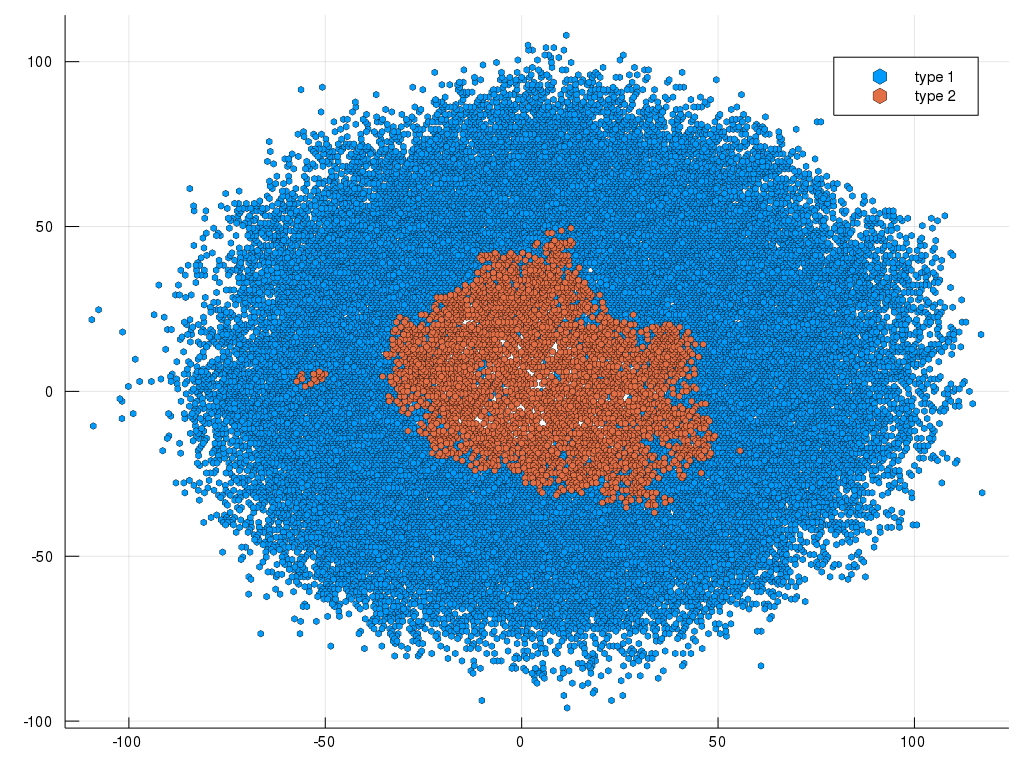

In [107]:
plot_hex_config(test)

Everything after here is random stuff I've been working on.  Let us know if you have any questions!

--Tim

# Immunotherapy example


In [9]:
using BenchmarkTools, Random

α1  = 0.5  # tumor migration rate
α2  = 2.0  # immune cell migration rate

β  = 0.03 # tumor reproduction rate
γ1 = 0.2  # immune cell predation rate
γ2 = 0.0000002 # immune cell recruitment rate
δ1 = 0.01 # tumor death rate
δ2 = 0.01 # immune cell death rate
ω  = 0.00000001 # dummy type


λ = 0.02  # immune cell production rate

κ = 0.2 # fibrosis production rate, ~50% of eating produces fibrosis
Κ = 0.02 # slow porous


param = [α1, α2, β, γ1, γ2, δ1, δ2, λ, ω, κ, Κ];

skeleton = @def_reactions begin
  T + 0 --> 0 + T, α1
  I + 0 --> 0 + I, α2
  T + 0 --> T + T, β
  I + T --> I + 0, γ1
  I + T --> I + I, γ2
  B + 0 --> B + I, λ
  T --> 0, δ1
  I --> 0, δ2
  D + 0 --> D + 0, ω
  F + I --> I + F, Κ
  I + T --> I + F, κ

end α1 α2 β γ1 γ2 δ1 δ2 λ ω κ Κ

model = @enumerate_with_sclass skeleton :hexagon 2 param ;

In [75]:
#Random.seed!(5357)
points = generate_random_2Dpoints((-4, 4), (-4, 4), 0.3)
ptypes = rand(1:1, size(points, 2)) # prey - 1, predator - 2

# add the barriers in
inner_barrier = generate_bordered_2D_hexgrid(75, 0.8)
outer_barrier = generate_bordered_2D_hexgrid(76, 0.8)

# add barrier locations
points = hcat(points, inner_barrier)
points = hcat(points, outer_barrier)

# add barrier types
append!(ptypes, 3 .* ones(length(inner_barrier[1, :])))
append!(ptypes, 4 .* ones(length(outer_barrier[1, :])))
state = SLattice(points, ptypes, model, number_types=5, nbhood = :hexagonal);

In [93]:
test = simulate(state, model, Direct(), 200.0, HasRates) ; 

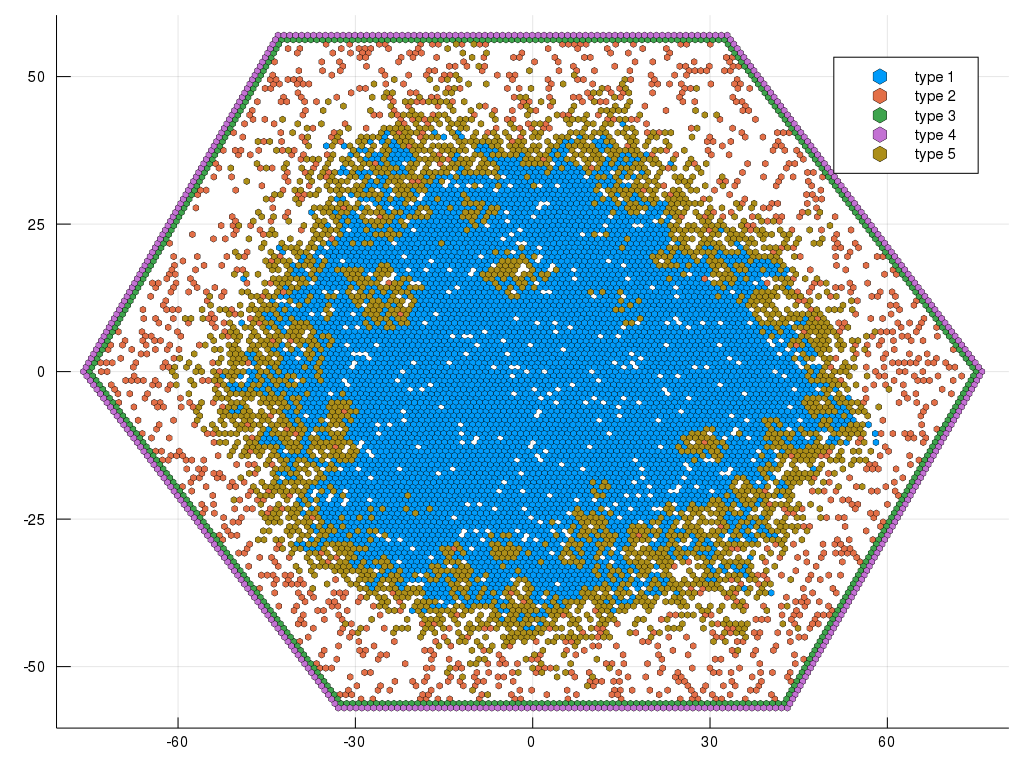

In [103]:
include("LatticeSimulator-notebook-utils.jl")
plot_hex_config(test)

## With "chemotaxis"

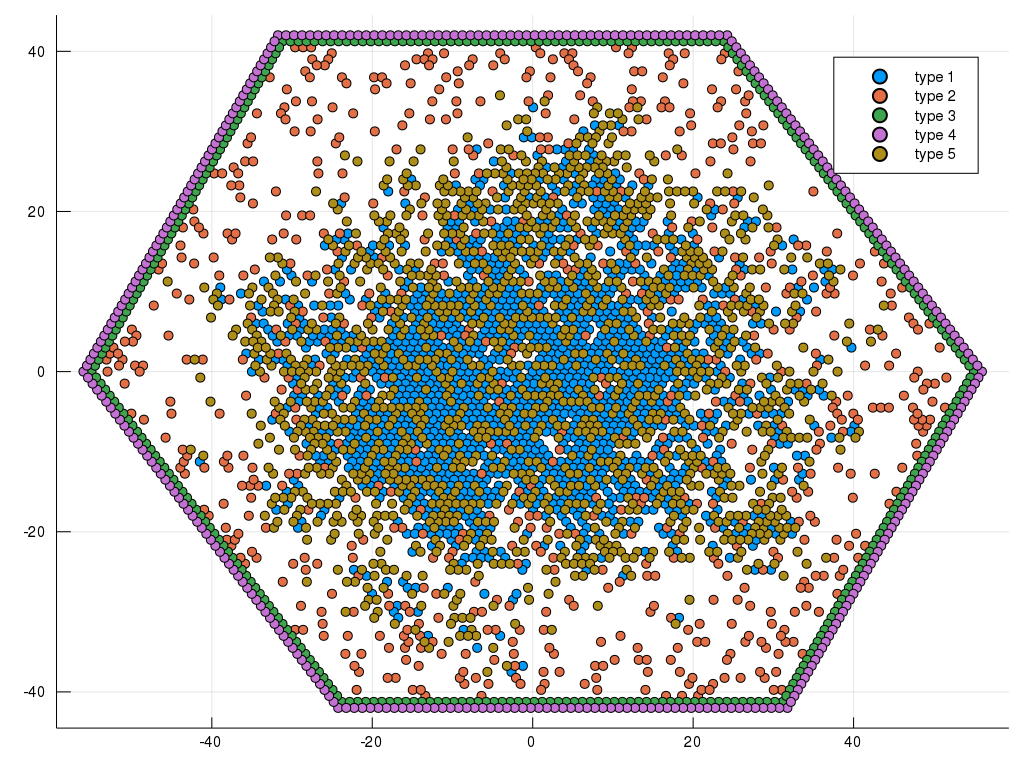

In [37]:
plot_hex_config(test)

## Without chemotaxis

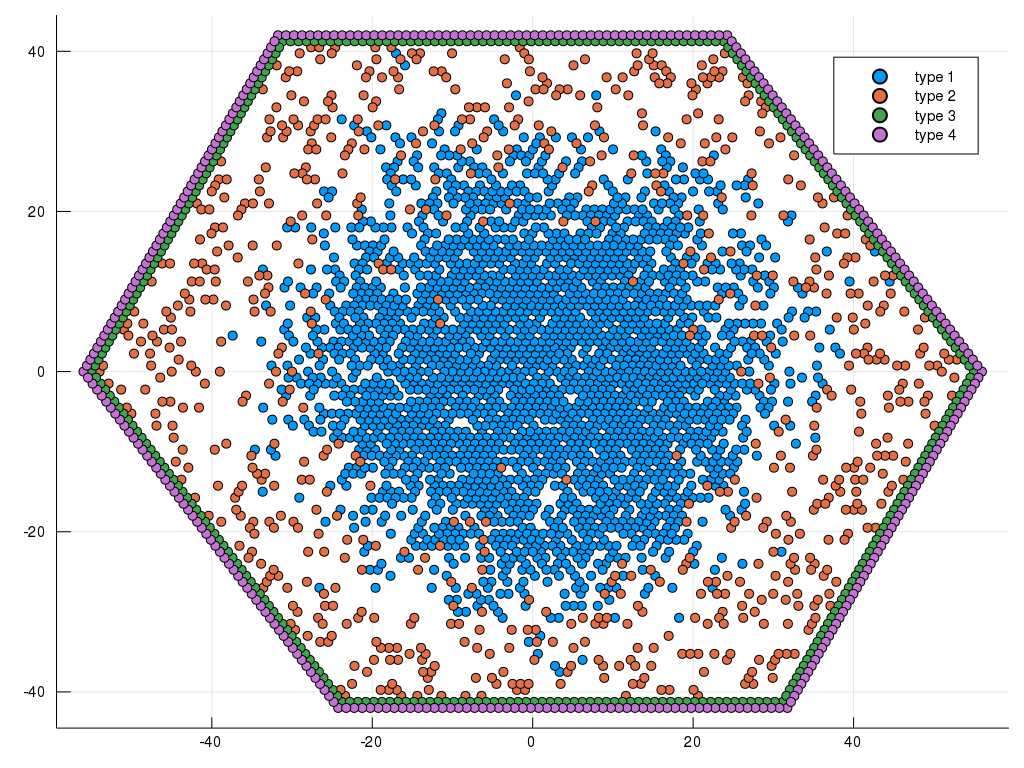

In [31]:
plot_hex_config(test)